<a href="https://colab.research.google.com/github/tmkhang1999/YOLOv8-DeepSORT-PaddleOCR-Supervision-Vehicle-Management-System/blob/main/Vehicle_Quick_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [ ]:
import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/tmkhang1999/YOLOv8-DeepSORT-PaddleOCR-Supervision-Vehicle-Management-System.git
else:
    sys.path.append('..')

In [ ]:
cd './YOLOv8-DeepSORT-PaddleOCR-Supervision-Vehicle-Management-System'

In [ ]:
!pip install supervision==0.1.0
!pip install deep-sort-realtime==1.3.1
!pip install ultralytics
!pip install opencv-python
!pip install paddlepaddle-gpu
!pip install paddleocr
!pip install pyaml_env

In [ ]:
!wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.0g-2ubuntu4_amd64.deb
!sudo dpkg -i libssl1.1_1.1.0g-2ubuntu4_amd64.deb

In [33]:
from ultralytics import YOLO
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import Color, ColorPalette
from supervision.notebook.utils import show_frame_in_notebook

# Set up videos and models

In [18]:
SOURCE_VIDEO_PATH = "./data/videos/vehicle-counting.mp4"
TARGET_VIDEO_PATH = "output.mp4"

In [21]:
model = YOLO("./data/models/yolov8x.pt")
model.fuse()

100%|██████████| 131M/131M [00:02<00:00, 63.6MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [22]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [2, 3, 5, 7]
CLASS_DICT = {}
for id in CLASS_ID:
    CLASS_DICT[id] = CLASS_NAMES_DICT[id]
print(CLASS_DICT)

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}


# Inference on a single frame

In [27]:
# Create VideoInfo instance, frame generator
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=1)

In [28]:
# Get the first 50th video frame
for _ in range(50):
    iterator = iter(generator)
    frame = next(iterator)

## Detect vehicle

In [29]:
# Predict with the confidence threshold 0.7
results = model(frame, conf=0.7)


0: 384x640 4 cars, 1 truck, 3823.3ms
Speed: 6.7ms preprocess, 3823.3ms inference, 23.0ms postprocess per image at shape (1, 3, 384, 640)


In [30]:
print(results[0].boxes.data)

tensor([[4.5616e+02, 1.1411e+03, 1.0226e+03, 1.8754e+03, 9.5184e-01, 7.0000e+00],
        [1.0889e+03, 1.8500e+03, 1.5457e+03, 2.1546e+03, 9.0519e-01, 2.0000e+00],
        [3.2012e+03, 1.4668e+03, 3.5487e+03, 1.7334e+03, 9.0470e-01, 2.0000e+00],
        [1.2995e+03, 1.5648e+03, 1.6354e+03, 1.8905e+03, 8.9556e-01, 2.0000e+00],
        [2.3887e+03, 9.4114e+02, 2.5439e+03, 1.0664e+03, 7.4615e-01, 2.0000e+00]])


## Annotate Vehicle

In [31]:
# model predictions to supervision Detections
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

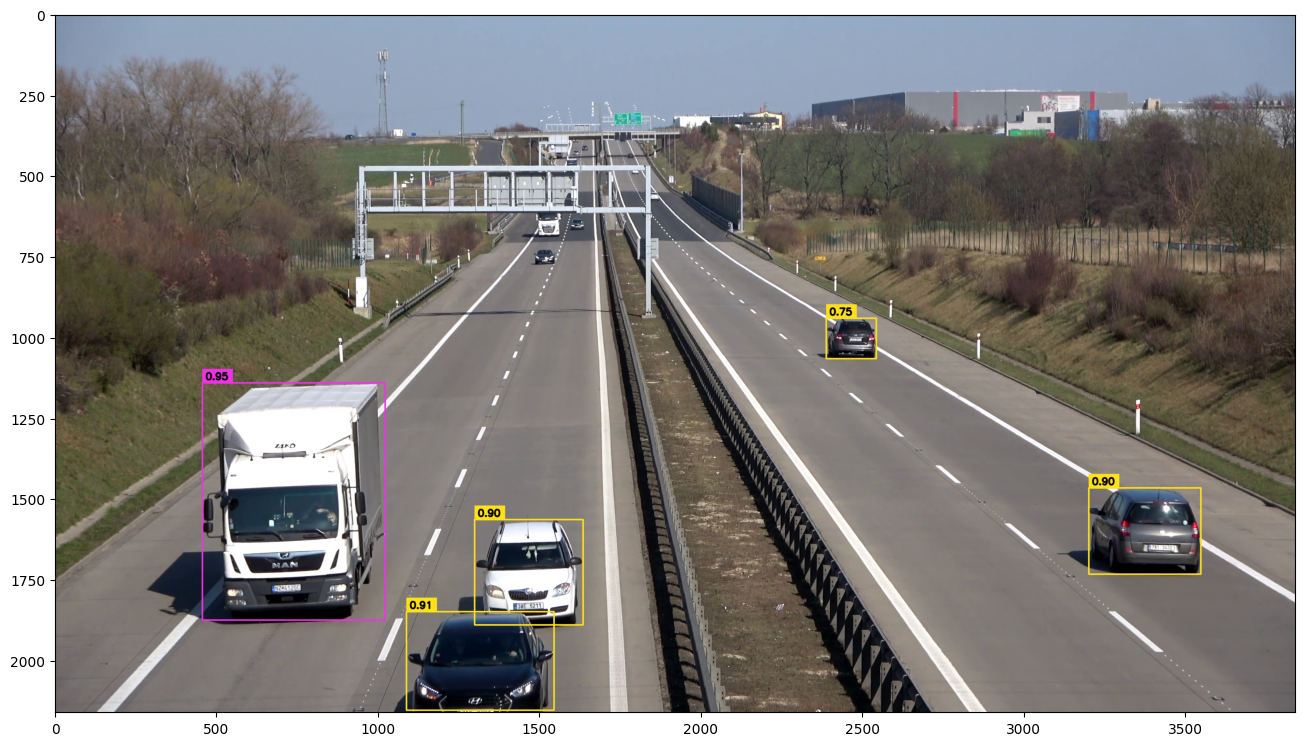

In [34]:
# annoate and display frame
%matplotlib inline
frame_ = frame.copy()
frame_ = box_annotator.annotate(frame=frame_, detections=detections, labels=None)
show_frame_in_notebook(frame_, (16, 16))

## Detect and annotate plate

In [35]:
license_plate_detector = YOLO("./data/models/license_plate_detector.pt")

In [36]:
from paddleocr import PaddleOCR

ocr_model = PaddleOCR(lang='en', show_log=False, use_angle_cls=True, use_gpu=False)

/usr/local/lib/python3.10/dist-packages/paddle/fluid/framework.py:549: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:16<00:00, 247kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:20<00:00, 509kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:12<00:00, 178kiB/s]


In [37]:
from modules.plate_recognition import PlateRecognizer

plate_recognizer = PlateRecognizer(license_plate_detector, ocr_model)

In [38]:
import numpy as np

for data in results[0].boxes.data.cpu().numpy():
    x1, y1, x2, y2, car_conf, label = data
    car_frame = frame[int(y1):int(y2), int(x1):int(x2)]
    plates = license_plate_detector(car_frame, conf=0.7)

    if plates[0]:
        x1_, y1_, x2_, y2_, plate_conf, label = plates[0].boxes.data.cpu().numpy()[0]
        plate_frame = car_frame[int(y1_):int(y2_), int(x1_):int(x2_)]

        result = ocr_model.ocr(plate_frame, cls=True)
        if result:
            info = result[0][0][-1]
            print(f"Licence Plate: {info[0]}, Conf: {info[1]}, Car_conf: {car_conf}, Plate_conf: {plate_conf}")

            # Visualize the plates
            text = f"[{info[0]}] Conf: {info[1]:0.2f}"
            frame_ = plate_recognizer.annotate(frame_, np.array([x1, y1, x2, y2]), text)
        else:
            print(f"None, Car_conf: {car_conf}, Plate_conf: {plate_conf}")
        print("-"*80)


0: 640x512 1 license_plate, 214.7ms
Speed: 3.9ms preprocess, 214.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)

0: 448x640 (no detections), 144.7ms
Speed: 3.6ms preprocess, 144.7ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)



Licence Plate: NZ412GC, Conf: 0.9030042290687561, Car_conf: 0.9518399238586426, Plate_conf: 0.7429219484329224
--------------------------------------------------------------------------------


0: 512x640 (no detections), 157.4ms
Speed: 3.6ms preprocess, 157.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 (no detections), 190.5ms
Speed: 5.2ms preprocess, 190.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 544x640 (no detections), 202.5ms
Speed: 5.5ms preprocess, 202.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


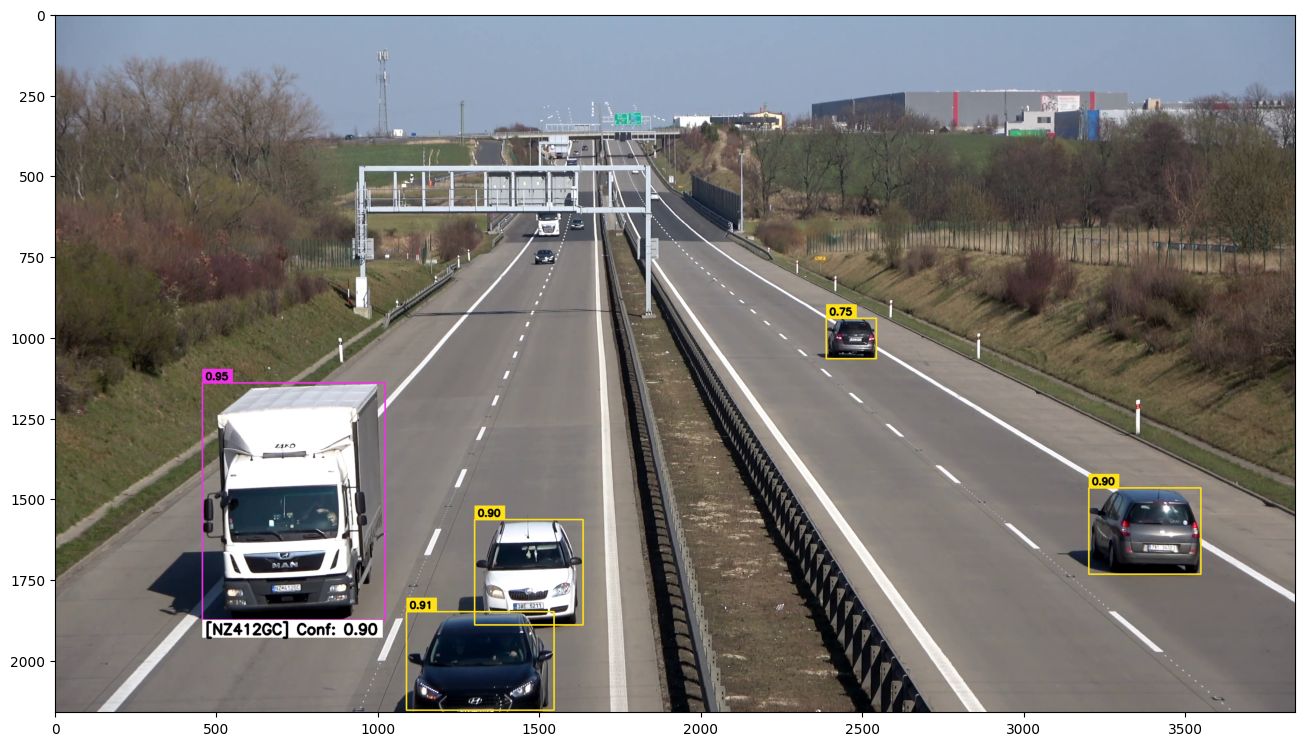

In [39]:
show_frame_in_notebook(frame_, (16, 16))

# Infernce on video

In [ ]:
!python main.py --config-path ./utils/config.yml --source-video ./data/videos/vehicle-counting.mp4 --target-video ./output.mp4